# An introduction to the Cross-Entropy Method

I recently stumbled across the Cross-Entropy Method (CEM), which is an important sampling method for optimizing black-box functions without gradient information. This method can be used in a number of reinforcement learning scenarios and it seemed useful to learn more about it. I highly recommend [this article](https://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf), which gives a nicely written introduction to the CEM. This blog post largely follows this article and supplements it with practical examples written in Python using scipy and numpy.

In [549]:
import math
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import numpy.random as random
random.seed(0)

import networkx as nx

## Rare event simulation and importance sampling

Assume we have a random Graph with random edges of probabiliy $p=0.1$ and 


The graph has edge weights $x = (x_1, x_2, \dots x_{n_\text{edges}})$, where each edge $x_j$ is exponentially distributed with mean $u_j$. The probability density function is therefore

$$
f(x; u) = \exp\left\{- \sum_{i=1}^{n_\text{edges}} \frac{x_j }{u_j}\right\} \prod_{i=1}^{n_\text{edges}} \frac{1}{u_j}
$$

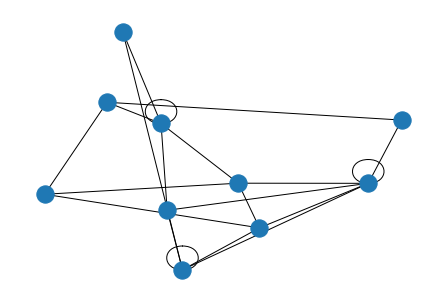

In [550]:
# compute random variables for each edge:
def gen_edge_weights(nedges, scale_params):
  edge_weights = np.array([random.exponential(scale=ui) for ui in scale_params])
  return edge_weights

def reset_edge_weights(adjacency_matrix, data_rvs=gen_edge_weights, scale_params=None):
  if scale_params == None:
    scale_params = [1 for i in range(0, adjacency_matrix.nnz)]
  adjacency_matrix.data = data_rvs(adjacency_matrix.nnz, scale_params)
  return adjacency_matrix

# generate the graph
def generate_graph(nnodes=10, density=0.2, data_rvs=gen_edge_weights, scale_params=None):
  adjacency_matrix = sparse.random(nnodes, nnodes, density=density)
  adjacency_matrix = reset_edge_weights(adjacency_matrix, data_rvs=gen_edge_weights, scale_params=scale_params)
  adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
  return adjacency_matrix

adjacency_matrix = generate_graph()  
graph = nx.from_scipy_sparse_matrix(adjacency_matrix)
nx.draw(graph)

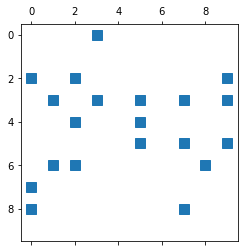

In [551]:
plt.spy(adjacency_matrix)

We want to estimate the probability of the shortest path exceeding a certain value. One way to do this is a crude Monte-Carlo simulation. We can look at the distribution by sampling different graphs and evaluating the shortest path between the first and last node. This quickly becomes intractable.

(array([1.519e+03, 2.660e+03, 2.230e+03, 1.513e+03, 9.050e+02, 5.340e+02,
        3.200e+02, 1.330e+02, 8.800e+01, 4.300e+01, 2.100e+01, 1.400e+01,
        4.000e+00, 5.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([6.88652916e-03, 6.44639829e-01, 1.28239313e+00, 1.92014643e+00,
        2.55789973e+00, 3.19565303e+00, 3.83340633e+00, 4.47115963e+00,
        5.10891292e+00, 5.74666622e+00, 6.38441952e+00, 7.02217282e+00,
        7.65992612e+00, 8.29767942e+00, 8.93543272e+00, 9.57318602e+00,
        1.02109393e+01, 1.08486926e+01, 1.14864459e+01, 1.21241992e+01,
        1.27619525e+01]),
 <BarContainer object of 20 artists>)

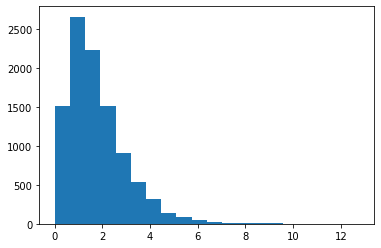

In [552]:
# get the shortest path from the first index to the last index
def compute_shortest_path(adjacency_matrix):
  dist_matrix = sparse.csgraph.shortest_path(adjacency_matrix, indices=0) # computes distance from index 0 to 1
  return dist_matrix[-1]

niter = 10000

dists = []
for i in range(0, niter):
  reset_edge_weights(adjacency_matrix)
  d = compute_shortest_path(adjacency_matrix)
  dists.append(d)

plt.hist(dists, bins=20)

We observe that the data seems to follow a beta distribution. We can also use this to estimate the probability of the shortest path exceeding a certain length, i.e.

$$
P(S(X) \geq \gamma) = \mathbb{E}[I_{\{S(X) \geq \gamma\}}]
$$

This quantity can be estimated using the unbiased estimator

$$
l
$$

In [553]:
dists = np.array(dists)
gamma = 4.0
print("P(S >= 4) =", len(dists[dists >= gamma]) / len(dists))

P(S >= 4) = 0.0534


As only a small fractions of paths satisfy this condition, it will take a large number of potentially costly evaluations to determine this quantity to a high precision. This is especially the case for a large $\gamma$. An alternative approach is to sample the distribution in a way that adaptively samples the extreme cases more often, and to later account for this bias in sampling. This idea is also called *importance sampling* (IS). We replace the original probability density function $f(X)$ with $g(X)$, and evaluate

$$
P(S(X) \geq \gamma) = \int I_{\{S(x) \geq \gamma\}} \frac{f(x)}{g(x)} g(x) \, \mathrm{d}x = \mathbb{E}_g\left[I_{\{S(X) \geq \gamma\}} \frac{f(X)}{g(X)} \right],
$$

which corresponds to the expected value taken with respect to $g(X)$. Effectively, $g$ represents a change of measure, which helps us determine the rare event probability more effectively. As such, it is also called the importance sampling density.

We can now use Monte-Carlo simulation again to estimate $P(S(X) \geq \gamma)$, using the unbiased estimator

$$
\hat{l} = \frac{1}{N} \sum_{i=1}^N I_{\{S(X) \geq \gamma\}} W(X_i),
$$

where we have introduced the likelihood ratio $W(x) = f(x)/g(x)$. In our case we can choose $X_i$ to be exponentially distributed with mean $v_i$. This yiedlds the likelihood ratio

$$
W(x; u, v) = \frac{f(x; u)}{f(x; v)} = \exp\left\{- \sum_{j=1}^{n_\text{edges}} x_j \left( \frac{1}{u_j} - \frac{1}{v_j}\right)\right\} \prod_{j=1}^{n_\text{edges}} \frac{v_j}{u_j}
$$

Let us begin by implementing the likelihood ratio $W$:

In [554]:
# Let us first set two
u = [1 for _ in range(0, adjacency_matrix.nnz)]
v = [1.6 for _ in range(0, adjacency_matrix.nnz)] # this value is completely arbitrary for the moment.

def likelihood_ratio(x, u, v):
  assert(len(x) == len(u) == len(v))
  nedges = len(x)
  ratio = 1.0
  for j in range(0, nedges):
    ratio = ratio * math.exp( -1.0 * x[j] * (1 / u[j] - 1 / v[j]) ) * v[j] / u[j]
  return ratio

likelihood_ratio(adjacency_matrix.data, u, v)

25.500007088995858

Let us use this to estimate the probability from before:

In [555]:
lhat = 0
lhats = []
for i in range(0, niter):
  adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=v)
  d = compute_shortest_path(adjacency_matrix)
  indicator = float(d >= gamma)
  w = likelihood_ratio(adjacency_matrix.data, u, v)
  lhat = lhat * i / (i+1) + w * indicator / (i+1) # update the running mean
  lhats.append(lhat)

print("P(S >= 4) =", lhat)


P(S >= 4) = 0.049658366765966654


There seems to be some discrepancy in the two estimators. Let us compare how both estimators, $l$ and $\hat{l}$ converge to the real probability:

In [556]:
l = 0
ls = []
for i in range(0, niter):
  adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=u)
  d = compute_shortest_path(adjacency_matrix)
  indicator = float(d >= gamma)
  l = l * i / (i+1) + indicator / (i+1) # update the running mean
  ls.append(l)

print("P(S >= 4) =", l)

P(S >= 4) = 0.05469999999999993


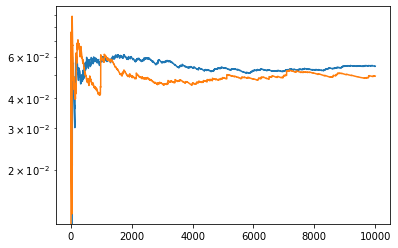

In [557]:
plt.semilogy(ls)
plt.semilogy(lhats)

We observe that the addition of the likelihood ratio allows the estimator to perform larger jumps, which corresponds to situations where 

A strength of the CE method is that it allows for an estimation of the optimal parameter $v$. The following algorithm determines $v$ iteratively, before it computes the estimated value:

In [565]:
nsamples = 100
elite_fraction = 0.1
nelites = math.ceil(elite_fraction * nsamples)

v = u
for iter in range(0, niter // nsamples):
  variables = []
  scores = []
  for isample in range(0, nsamples):
    adjacency_matrix = reset_edge_weights(adjacency_matrix, scale_params=u)
    d = compute_shortest_path(adjacency_matrix)
    variables.append(adjacency_matrix.data)
    scores.append(d)
  elite_indices = np.argsort(scores)[-nelites:]
  print(elite_indices)
  
  
  
    

[28 81 20 33 24 85 19 25 93 92]
[23 73 57 66 80 19 14 13 78  1]
[36 86 22 71 26 89 11  3  9 47]
[60 62 75 87 41 53  0 15 37 48]
[42 41 27 84  8  4 67 45  7  3]
[53 38 76 89  0 49 23 42 80  8]
[57 46 86 38 75 53 15 68 24 51]
[16 13 95 80 17 70 82 35 76 26]
[15 25 24 64 96 82 99 49 92 28]
[55 34 64 37 87 29 32 84 93 41]
[45  3 18 49 82 19 65  9 41 97]
[38 18  3  5 31 86 79 99 50 28]
[62 28  6 22 32 19 74 16 76 84]
[13 62 30 65 38 12 25 32 53 42]
[12 45 47 30 36  0 76 55 78  6]
[87 97 91 38  3 81 67 84 69 19]
[ 6 38 96 35 11 29 78 98 46 91]
[55 73 58 89 95 77 86  9 34 40]
[96 65 46 17 56 26 64 80 91 93]
[ 0 17 10 35 54 45 87 24 36 51]
[46 65 62 26 27 87 39 79 47 60]
[73 88 77 27 97 96 58 30  8  6]
[72  1 33 97 46 29 40  8 86 49]
[56 29 48 67 30 39 13 41 49 34]
[15 10 87 55 50 24 19 12 21 18]
[51  7 13 77 65 94 58 46 68 50]
[77 93 43 46 96 50 23  2 33 75]
[90 55 61 87 68 42 60 18 51 80]
[79  4 48 95 56 44  6 94 18 58]
[88 40 62 58 92 71 85 25 20 60]
[56 25 83  8 30 27 52 97 40 78]
[41 83 2

## Application to reinforcement learning

A difficult setting for optimizers is policy search in reinforcement learning.

## References

- [https://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf](https://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf)